In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img
import random


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [ ]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model

In [ ]:
DATA_DIR = '/content/drive/MyDrive/imagenet_10cls_V2'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Validation')

In [ ]:
IMG_SIZE = 64
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['Spider', 'Lion', 'Pizza', 'jellyfish', 'Deer', 'Dragonfly', 'Butterfly', 'Car', 'Stork_Bird', 'kettle']


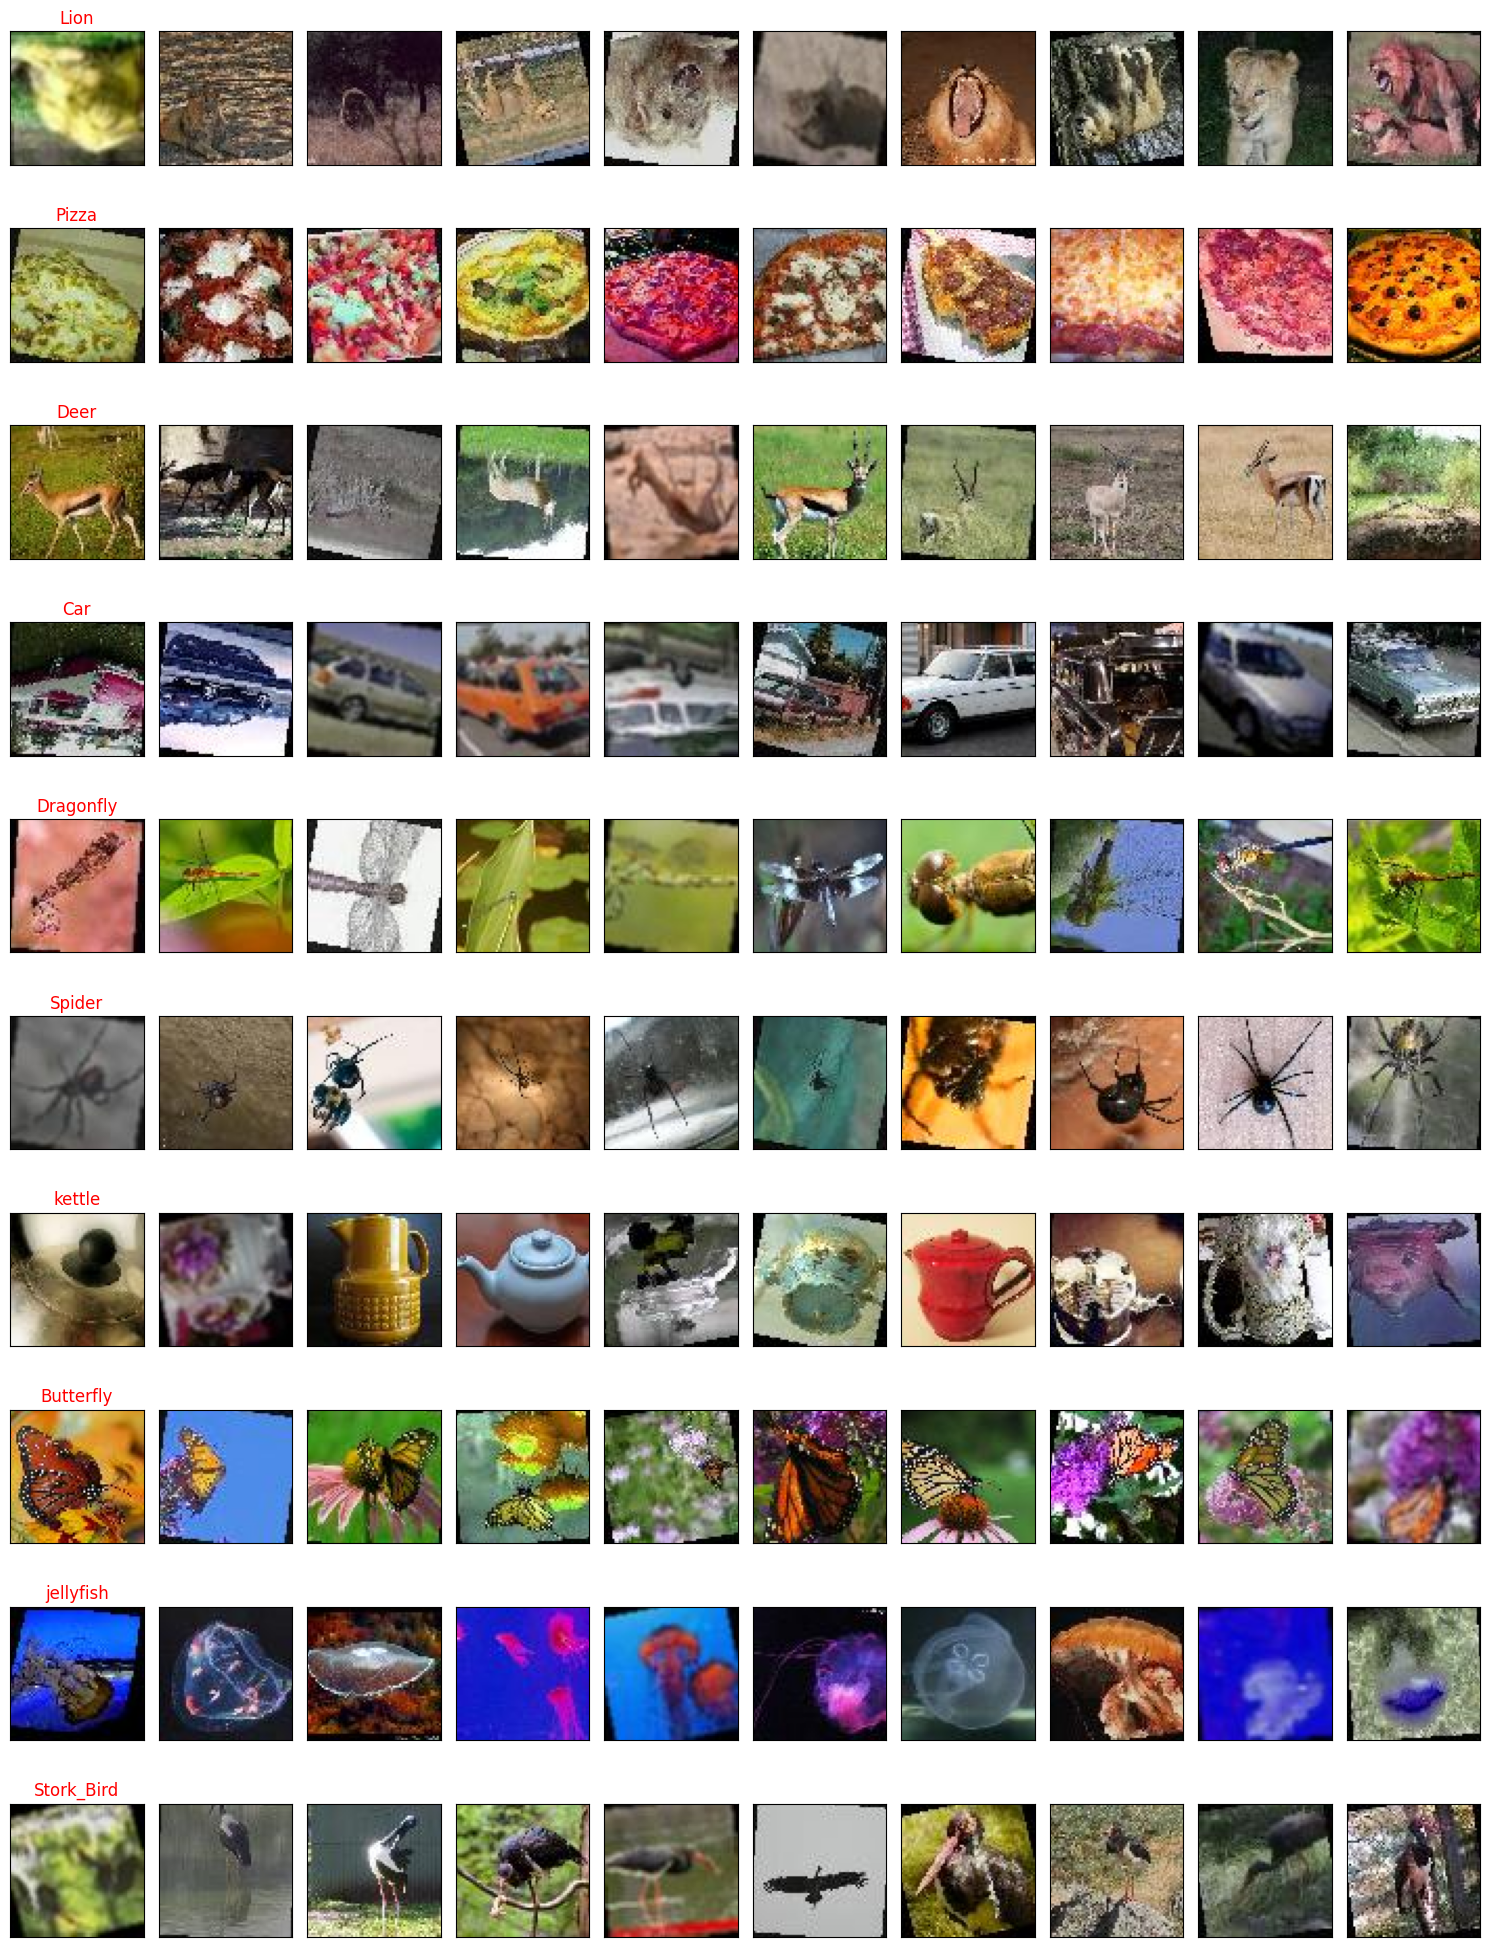

In [ ]:
plt.figure(figsize=(15, 20), facecolor='white')
i = 1
for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    random.shuffle(image_list)
    image_list = image_list[:10]
    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array
        plt.subplot(10, 10, i)
        plt.imshow(white_background)
        if i % 10 == 1:
            plt.title(c, color='red')
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

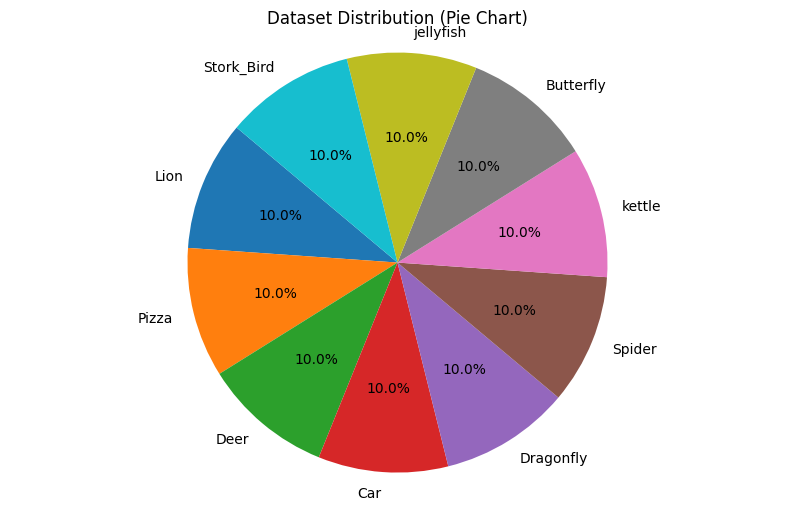

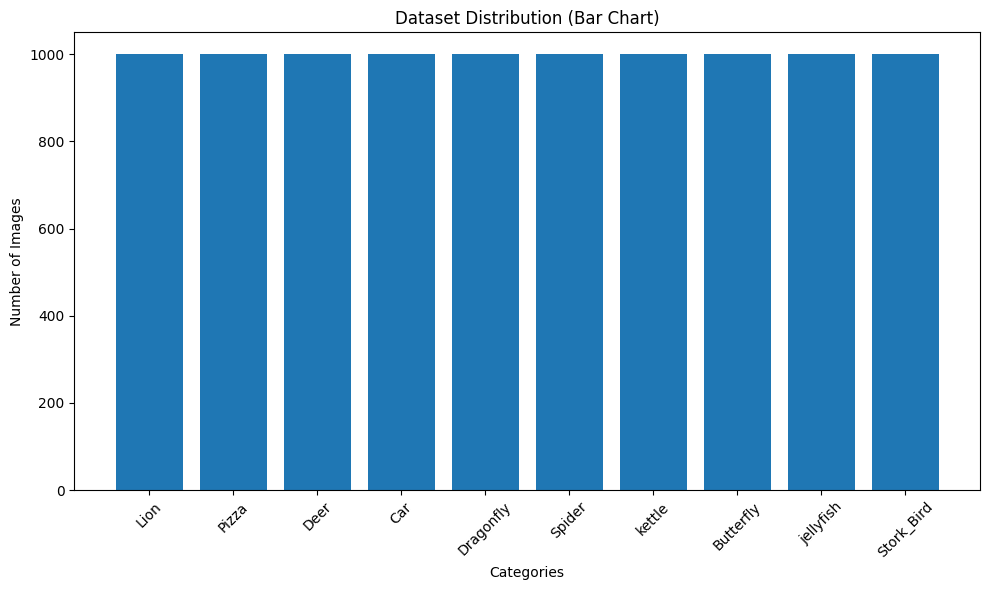

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.tits('equal')
plt.show()
le('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 1000/1000 [00:23<00:00, 42.63it/s]

10020


In [ ]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 250/250 [00:04<00:00, 54.66it/s] 

2500


In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (10020, 64, 64, 3) Y_train= (10020,)


In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (2500, 64, 64, 3) Y_test= (2500,)


Basic CNN

In [ ]:
bcnn_model = Sequential()
bcnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(64, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(128, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Flatten())
bcnn_model.add(Dense(128, activation='relu'))
bcnn_model.add(Dropout(0.5))
bcnn_model.add(Dense(len(CATEGORIES), activation='softmax'))

In [ ]:
bcnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bcnn = bcnn_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/200
157/157 [==============================] - 4s 15ms/step - loss: 0.7932 - accuracy: 0.7256 - val_loss: 0.5466 - val_accuracy: 0.8215
Epoch 2/200
157/157 [==============================] - 2s 12ms/step - loss: 0.7364 - accuracy: 0.7475 - val_loss: 0.5021 - val_accuracy: 0.8386
Epoch 3/200
157/157 [==============================] - 2s 13ms/step - loss: 0.6709 - accuracy: 0.7690 - val_loss: 0.4615 - val_accuracy: 0.8550
Epoch 4/200
157/157 [==============================] - 2s 12ms/step - loss: 0.6286 - accuracy: 0.7872 - val_loss: 0.4577 - val_accuracy: 0.8610
Epoch 5/200
157/157 [==============================] - 2s 12ms/step - loss: 0.5841 - accuracy: 0.7881 - val_loss: 0.4033 - val_accuracy: 0.8717
Epoch 6/200
157/157 [==============================] - 2s 12ms/step - loss: 0.5481 - accuracy: 0.8107 - val_loss: 0.4192 - val_accuracy: 0.8729
Epoch 7/200
157/157 [==============================] - 2s 12ms/step - loss: 0.5023 - accuracy: 0.8202 - val_loss: 0.3578 - val_accuracy:

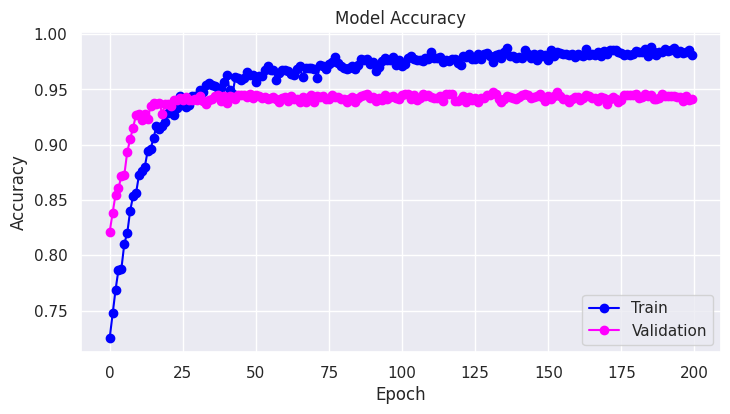

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['accuracy'], 'o-',color="blue")
plt.plot(bcnn.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

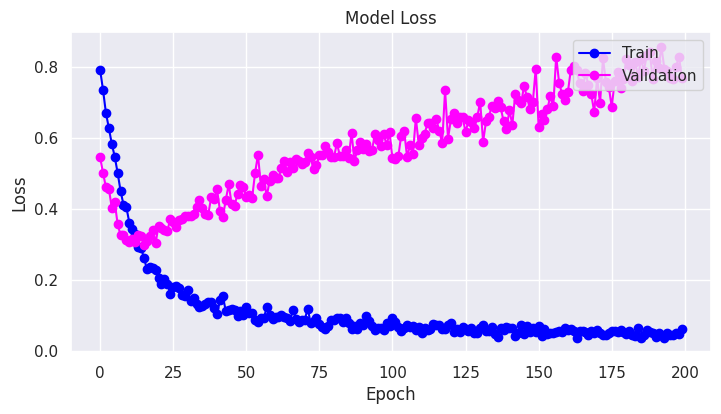

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['loss'],'o-', color="blue")
plt.plot(bcnn.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = bcnn_model.evaluate(X_test, Y_test)
train_loss, train_acc=bcnn_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

313/313 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9991

Test Accuracy: 0.9414342641830444

Test Loss: 0.7702626585960388

Train Accuracy: 0.9991000294685364

Train Loss: 0.0021265705581754446


In [ ]:
score = bcnn_model.evaluate(X_test,Y_test,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  94.143 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(bcnn_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

79/79 [==============================] - 0s 3ms/step
[0 0 0 ... 9 9 0]
(2510,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[225,   5,   9,   1,   2,   1,   2,   0,   2,   3],
       [  0, 245,   0,   1,   1,   0,   2,   1,   0,   0],
       [ 12,   2, 235,   1,   2,   1,   3,   1,   0,   3],
       [  0,   0,   1, 247,   0,   0,   1,   0,   1,   0],
       [  3,   2,   1,   0, 234,   5,   2,   1,   2,   0],
       [  2,   1,   1,   1,   2, 235,   2,   1,   0,   5],
       [  5,   3,   4,   4,   1,   3, 225,   0,   1,   4],
       [  0,   0,   0,   0,   4,   0,   0, 246,   0,   0],
       [  2,   1,   2,   1,   0,   0,   3,   0, 240,   1],
       [  2,   0,   4,   3,   7,   2,   1,   0,   0, 231]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

        Lion      0.896     0.900     0.898       250
       Pizza      0.946     0.980     0.963       250
        Deer      0.914     0.904     0.909       260
         Car      0.954     0.988     0.971       250
   Dragonfly      0.925     0.936     0.930       250
      Spider      0.951     0.940     0.946       250
      kettle      0.934     0.900     0.916       250
   Butterfly      0.984     0.984     0.984       250
   jellyfish      0.976     0.960     0.968       250
  Stork_Bird      0.935     0.924     0.930       250

    accuracy                          0.941      2510
   macro avg      0.942     0.942     0.941      2510
weighted avg      0.941     0.941     0.941      2510



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'] , columns = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'])

<Axes: title={'center': 'Confusion Matrix'}>

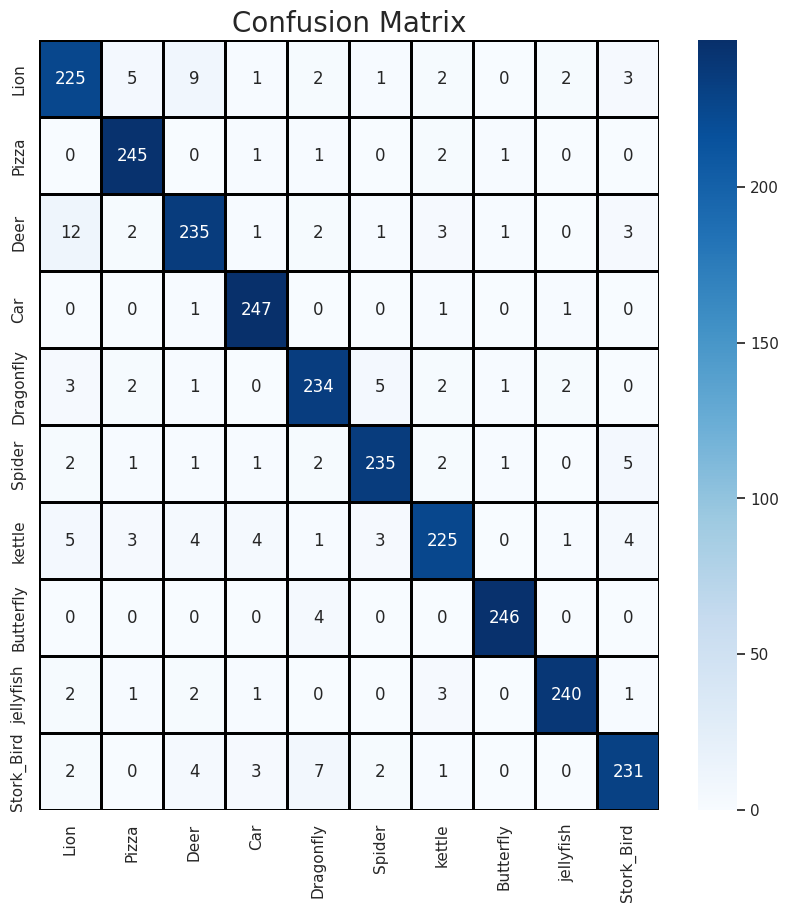

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 0s 3ms/step


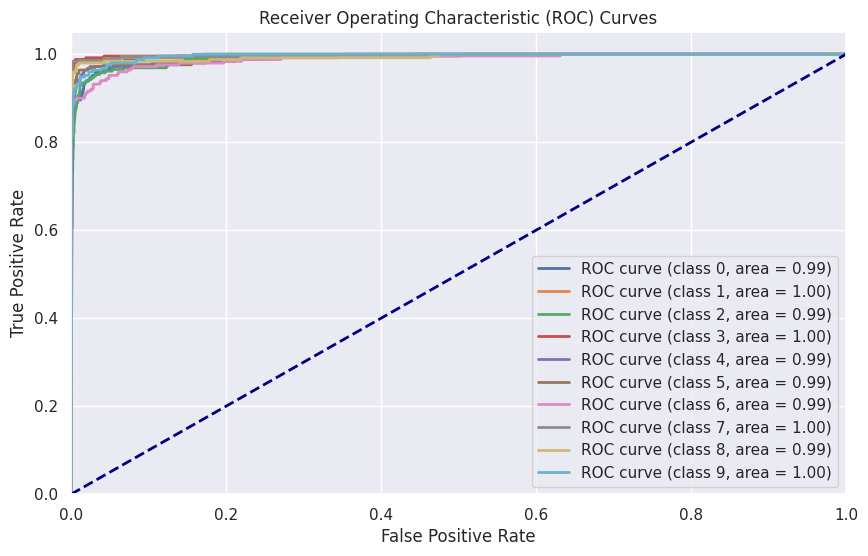

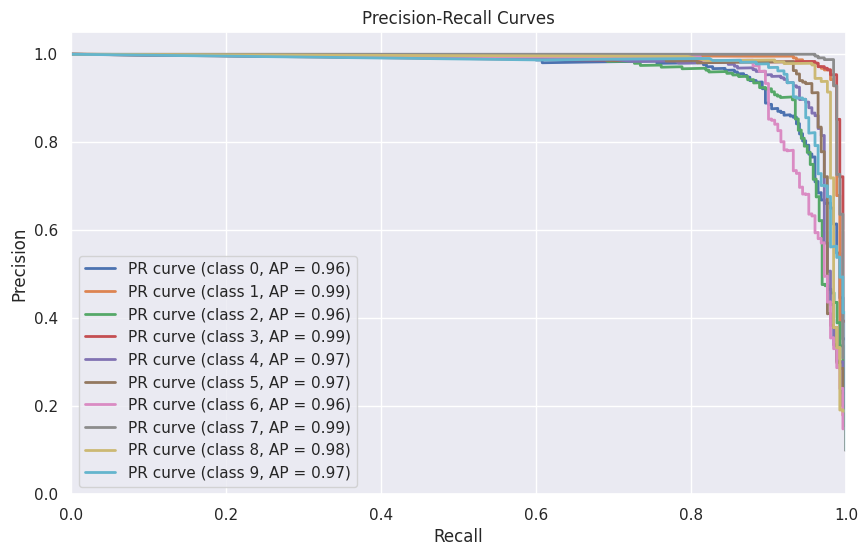

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = bcnn_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### ALEXNET

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
alexnet_model = keras.Sequential([
    ## input layer
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='valid'),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=128),
    layers.Activation('relu'),

    layers.Dense(units=64),
    layers.Activation('relu'),

    layers.Dense(units=10),
    layers.Activation('relu'),

    layers.Dense(len(CATEGORIES)),
    layers.Activation('softmax')
])

In [ ]:
alexnet_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alexnet = alexnet_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/200
157/157 [==============================] - 6s 18ms/step - loss: 2.0867 - accuracy: 0.2313 - val_loss: 1.8627 - val_accuracy: 0.3386
Epoch 2/200
157/157 [==============================] - 2s 15ms/step - loss: 1.7700 - accuracy: 0.3748 - val_loss: 1.5805 - val_accuracy: 0.4355
Epoch 3/200
157/157 [==============================] - 2s 14ms/step - loss: 1.6084 - accuracy: 0.4422 - val_loss: 1.4142 - val_accuracy: 0.5028
Epoch 4/200
157/157 [==============================] - 2s 14ms/step - loss: 1.4754 - accuracy: 0.4889 - val_loss: 1.2766 - val_accuracy: 0.5637
Epoch 5/200
157/157 [==============================] - 2s 13ms/step - loss: 1.3847 - accuracy: 0.5131 - val_loss: 1.1906 - val_accuracy: 0.5801
Epoch 6/200
157/157 [==============================] - 2s 13ms/step - loss: 1.3170 - accuracy: 0.5397 - val_loss: 1.1095 - val_accuracy: 0.6299
Epoch 7/200
157/157 [==============================] - 2s 13ms/step - loss: 1.2616 - accuracy: 0.5542 - val_loss: 1.0877 - val_accuracy:

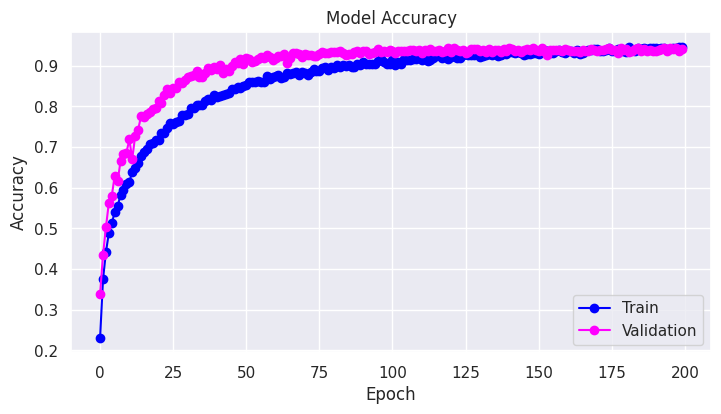

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['accuracy'], 'o-',color="blue")
plt.plot(alexnet.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

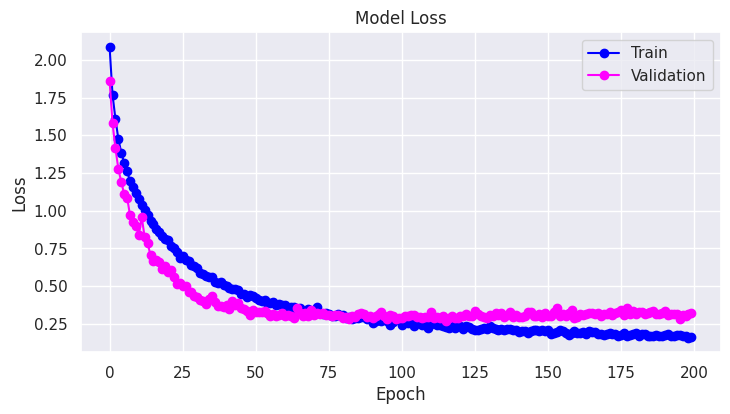

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(alexnet.history['loss'],'o-', color="blue")
plt.plot(alexnet.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])


In [ ]:
test_loss, test_acc = alexnet_model.evaluate(X_test, Y_test)
train_loss, train_acc=alexnet_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

313/313 [==============================] - 1s 4ms/step - loss: 0.0133 - accuracy: 0.9988

Test Accuracy: 0.9410358667373657

Test Loss: 0.3200744092464447

Train Accuracy: 0.9987999796867371

Train Loss: 0.013336270116269588


In [ ]:
score = alexnet_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  94.104 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(alexnet_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

79/79 [==============================] - 0s 3ms/step
[0 0 0 ... 9 9 0]
(2510,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[240,   0,   8,   0,   1,   0,   0,   0,   0,   1],
       [  4, 243,   0,   0,   0,   0,   2,   0,   1,   0],
       [ 13,   2, 238,   1,   3,   1,   0,   0,   0,   2],
       [  0,   1,   0, 244,   0,   1,   2,   0,   1,   1],
       [  2,   0,   4,   0, 225,   6,   2,   3,   2,   6],
       [  1,   0,   0,   2,   3, 235,   4,   3,   0,   2],
       [  9,   0,   5,   2,   2,   1, 225,   1,   2,   3],
       [  1,   0,   0,   0,   5,   1,   0, 242,   0,   1],
       [  1,   0,   3,   1,   1,   0,   4,   0, 240,   0],
       [  4,   1,   9,   0,   1,   1,   2,   2,   0, 230]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

        Lion      0.873     0.960     0.914       250
       Pizza      0.984     0.972     0.978       250
        Deer      0.891     0.915     0.903       260
         Car      0.976     0.976     0.976       250
   Dragonfly      0.934     0.900     0.916       250
      Spider      0.955     0.940     0.948       250
      kettle      0.934     0.900     0.916       250
   Butterfly      0.964     0.968     0.966       250
   jellyfish      0.976     0.960     0.968       250
  Stork_Bird      0.935     0.920     0.927       250

    accuracy                          0.941      2510
   macro avg      0.942     0.941     0.941      2510
weighted avg      0.942     0.941     0.941      2510



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'] , columns = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'])

<Axes: title={'center': 'Confusion Matrix'}>

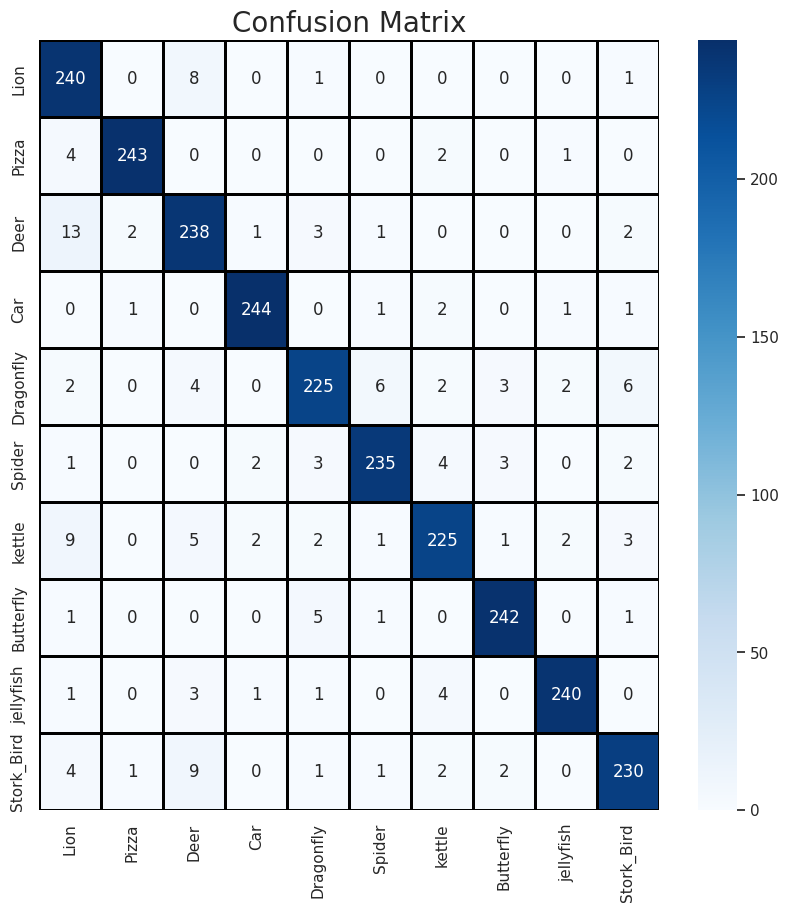

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 0s 3ms/step


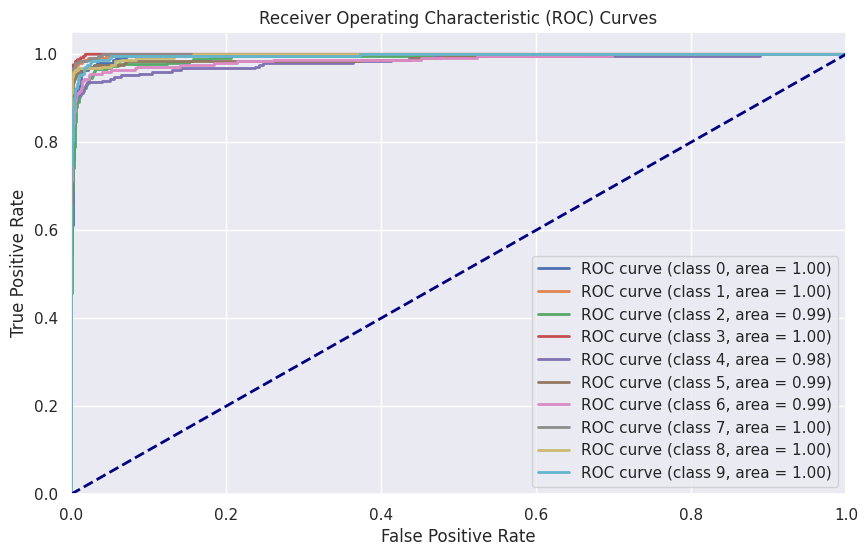

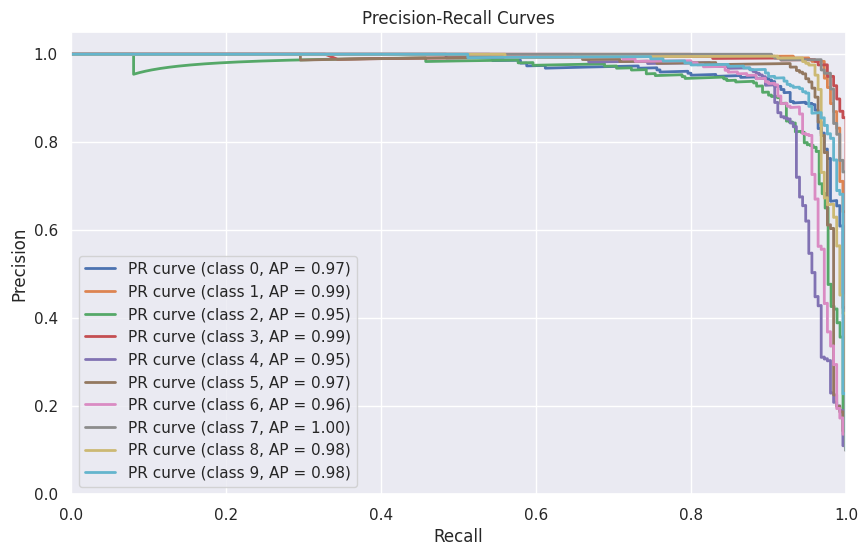

In [ ]:
# Calculate ROC and PR curves for each class
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = alexnet_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### Resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam

resnet50_model = ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))
training_model = Sequential()
training_model.add(resnet50_model)
training_model.add(Flatten())
training_model.add(Dense(128, activation='relu'))
training_model.add(Dense(10, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
training_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
resnet50 = training_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/200
157/157 [==============================] - 58s 103ms/step - loss: 2.4723 - accuracy: 0.1958 - val_loss: 2.4150 - val_accuracy: 0.0996
Epoch 2/200
157/157 [==============================] - 13s 85ms/step - loss: 1.8665 - accuracy: 0.3464 - val_loss: 2.5545 - val_accuracy: 0.1012
Epoch 3/200
157/157 [==============================] - 13s 85ms/step - loss: 1.5685 - accuracy: 0.4648 - val_loss: 1.8957 - val_accuracy: 0.3315
Epoch 4/200
157/157 [==============================] - 13s 84ms/step - loss: 1.3554 - accuracy: 0.5371 - val_loss: 1.7113 - val_accuracy: 0.4653
Epoch 5/200
157/157 [==============================] - 15s 97ms/step - loss: 1.2591 - accuracy: 0.5720 - val_loss: 3.2082 - val_accuracy: 0.2884
Epoch 6/200
157/157 [==============================] - 13s 83ms/step - loss: 1.2042 - accuracy: 0.5802 - val_loss: 1.0222 - val_accuracy: 0.6590
Epoch 7/200
157/157 [==============================] - 14s 86ms/step - loss: 1.0906 - accuracy: 0.6374 - val_loss: 0.9628 - val_a

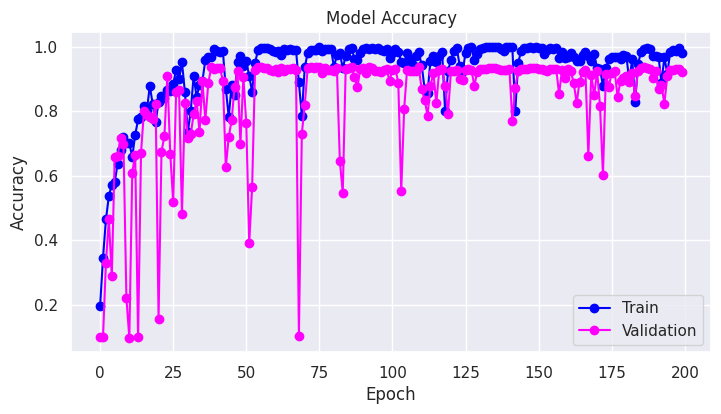

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(resnet50.history['accuracy'], 'o-',color="blue")
plt.plot(resnet50.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

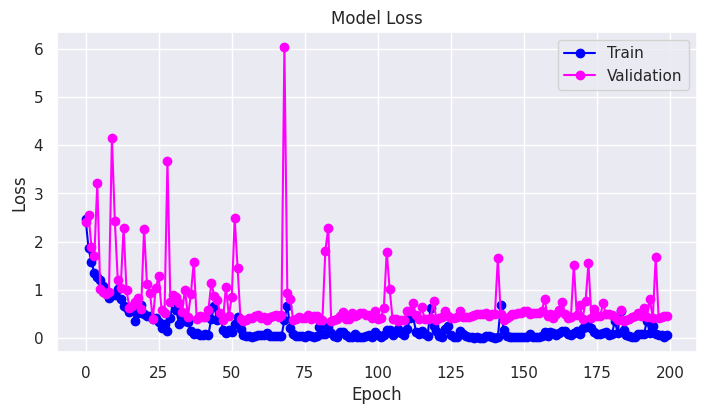

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(resnet50.history['loss'],'o-', color="blue")
plt.plot(resnet50.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = training_model.evaluate(X_test, Y_test)
train_loss, train_acc=training_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

313/313 [==============================] - 5s 15ms/step - loss: 0.0423 - accuracy: 0.9893

Test Accuracy: 0.9215139150619507

Test Loss: 0.46727651357650757

Train Accuracy: 0.989300012588501

Train Loss: 0.04230280965566635


In [ ]:
score = training_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  92.151 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(training_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

79/79 [==============================] - 2s 15ms/step
[0 0 0 ... 9 9 8]
(2510,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[220,   0,   6,   3,   3,   6,   3,   2,   1,   6],
       [  2, 237,   5,   2,   0,   1,   2,   0,   1,   0],
       [  7,   2, 235,   5,   5,   1,   3,   0,   1,   1],
       [  1,   0,   0, 243,   2,   1,   2,   0,   1,   0],
       [  2,   0,   3,   1, 220,   8,   2,   7,   2,   5],
       [  0,   0,   2,   4,   4, 232,   1,   2,   3,   2],
       [  3,   0,   5,   3,   0,   4, 229,   0,   3,   3],
       [  1,   1,   0,   1,   4,   0,   2, 240,   0,   1],
       [  2,   0,   0,   3,   0,   0,   5,   1, 237,   2],
       [  2,   0,   5,   3,   6,  10,   2,   0,   2, 220]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

        Lion      0.917     0.880     0.898       250
       Pizza      0.988     0.948     0.967       250
        Deer      0.900     0.904     0.902       260
         Car      0.907     0.972     0.938       250
   Dragonfly      0.902     0.880     0.891       250
      Spider      0.882     0.928     0.904       250
      kettle      0.912     0.916     0.914       250
   Butterfly      0.952     0.960     0.956       250
   jellyfish      0.944     0.948     0.946       250
  Stork_Bird      0.917     0.880     0.898       250

    accuracy                          0.922      2510
   macro avg      0.922     0.922     0.922      2510
weighted avg      0.922     0.922     0.921      2510



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'] , columns = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'])

<Axes: title={'center': 'Confusion Matrix'}>

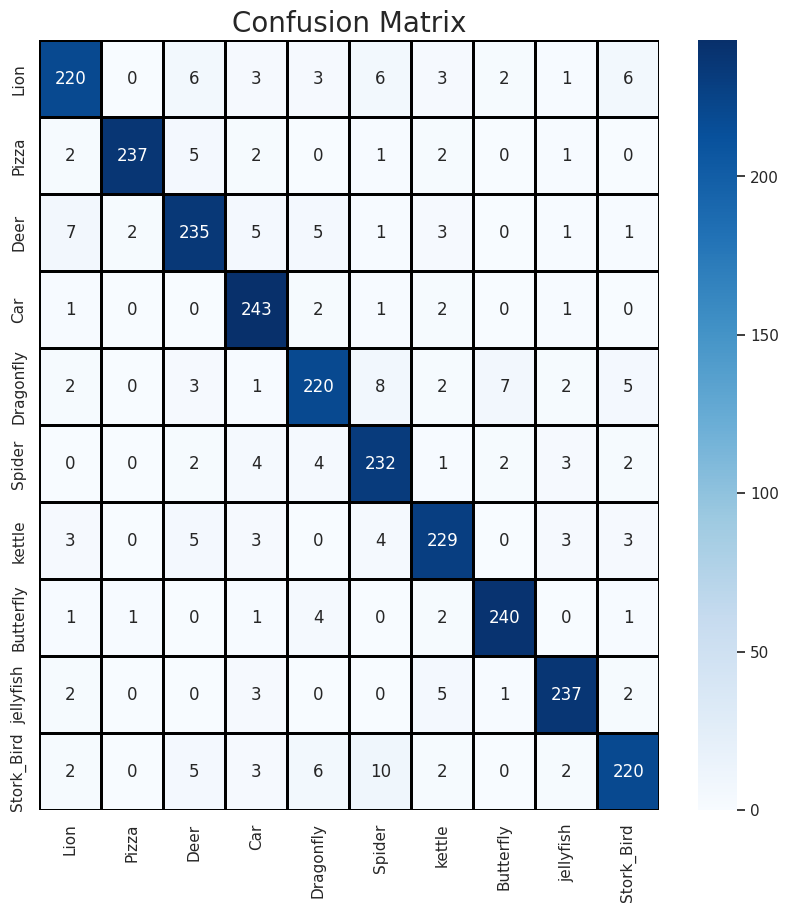

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 1s 15ms/step


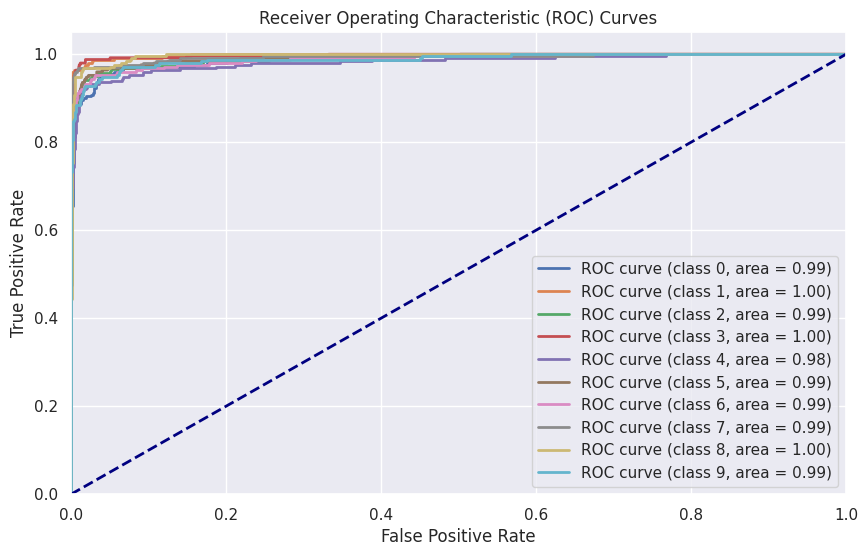

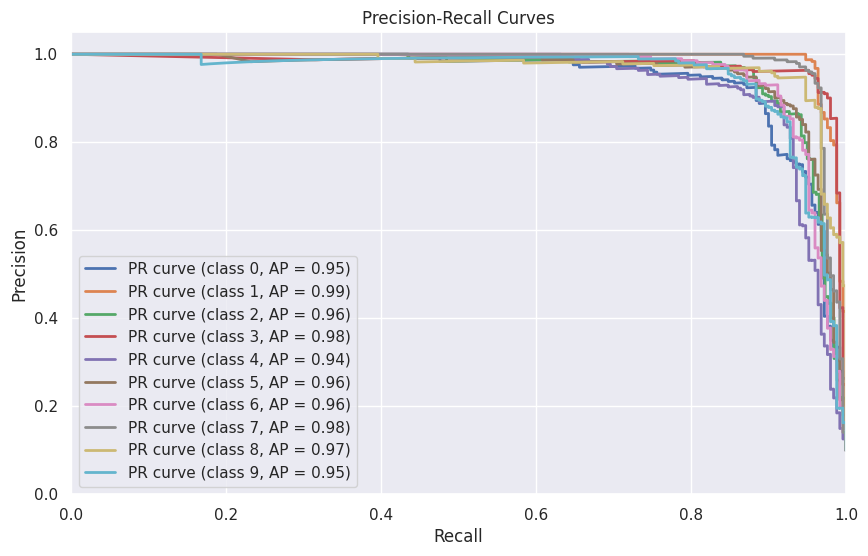

In [ ]:
# Calculate ROC and PR curves for each class
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = training_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### Resnet50(pretrain)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam

resnet_basic_model = ResNet50(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# Freeze all layers of the pre-trained model
for layer in resnet_basic_model.layers:
    layer.trainable = False
resnet_model = Sequential()
resnet_model.add(resnet50_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
resnet_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet50_pretrained = resnet_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/200
157/157 [==============================] - 53s 93ms/step - loss: 0.7560 - accuracy: 0.9430 - val_loss: 12.7162 - val_accuracy: 0.9108
Epoch 2/200
157/157 [==============================] - 14s 88ms/step - loss: 0.2275 - accuracy: 0.9677 - val_loss: 15.4383 - val_accuracy: 0.9155
Epoch 3/200
157/157 [==============================] - 13s 85ms/step - loss: 0.1545 - accuracy: 0.9762 - val_loss: 12.6915 - val_accuracy: 0.9199
Epoch 4/200
157/157 [==============================] - 13s 83ms/step - loss: 0.3644 - accuracy: 0.9337 - val_loss: 10.0566 - val_accuracy: 0.9020
Epoch 5/200
157/157 [==============================] - 13s 85ms/step - loss: 0.1041 - accuracy: 0.9787 - val_loss: 1.8512 - val_accuracy: 0.9275
Epoch 6/200
157/157 [==============================] - 13s 83ms/step - loss: 0.0697 - accuracy: 0.9889 - val_loss: 2.4212 - val_accuracy: 0.9191
Epoch 7/200
157/157 [==============================] - 13s 86ms/step - loss: 0.0474 - accuracy: 0.9889 - val_loss: 1.2375 - va

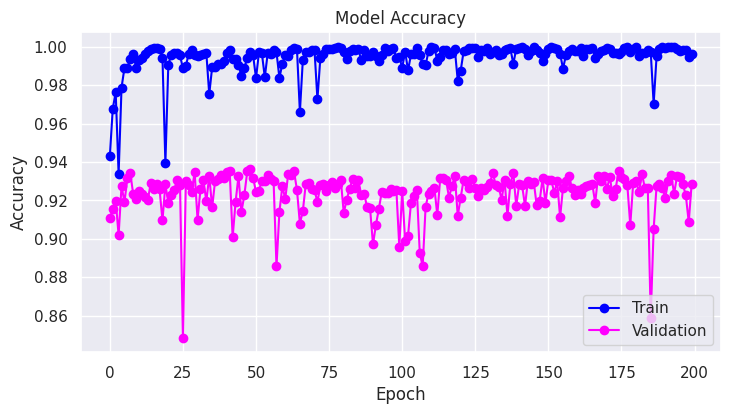

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(resnet50_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(resnet50_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

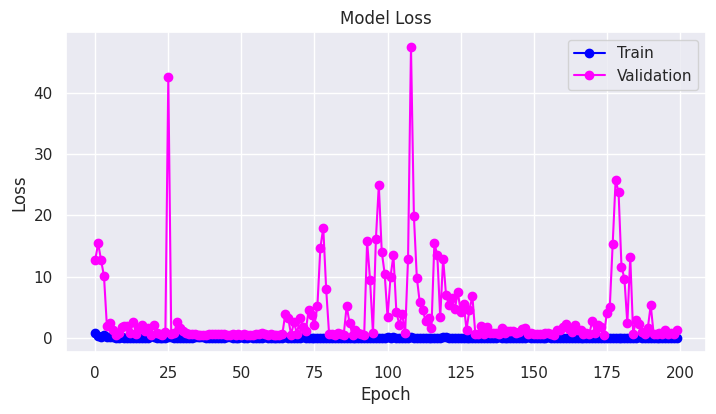

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(resnet50_pretrained.history['loss'],'o-', color="blue")
plt.plot(resnet50_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = resnet_model.evaluate(X_test, Y_test)
train_loss, train_acc=resnet_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

313/313 [==============================] - 5s 17ms/step - loss: 1.1409 - accuracy: 0.9915

Test Accuracy: 0.9286852478981018

Test Loss: 1.2509115934371948

Train Accuracy: 0.9915000200271606

Train Loss: 1.1409456729888916


In [ ]:
score = resnet_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  92.869 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(resnet_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

79/79 [==============================] - 2s 13ms/step
[0 0 0 ... 9 9 0]
(2510,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[222,   2,  10,   1,   2,   6,   2,   2,   0,   3],
       [  0, 244,   1,   2,   0,   0,   3,   0,   0,   0],
       [ 11,   2, 237,   2,   2,   2,   0,   0,   0,   4],
       [  0,   0,   0, 243,   1,   0,   3,   1,   0,   2],
       [  0,   0,   3,   0, 228,   4,   2,   5,   2,   6],
       [  1,   0,   2,   3,   3, 237,   0,   3,   0,   1],
       [  5,   1,   1,   5,   3,   3, 227,   3,   1,   1],
       [  0,   0,   0,   1,   3,   0,   1, 243,   1,   1],
       [  2,   1,   1,   2,   0,   0,  16,   2, 224,   2],
       [  4,   1,   7,   5,   0,   4,   2,   1,   0, 226]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

        Lion      0.906     0.888     0.897       250
       Pizza      0.972     0.976     0.974       250
        Deer      0.905     0.912     0.908       260
         Car      0.920     0.972     0.946       250
   Dragonfly      0.942     0.912     0.927       250
      Spider      0.926     0.948     0.937       250
      kettle      0.887     0.908     0.897       250
   Butterfly      0.935     0.972     0.953       250
   jellyfish      0.982     0.896     0.937       250
  Stork_Bird      0.919     0.904     0.911       250

    accuracy                          0.929      2510
   macro avg      0.929     0.929     0.929      2510
weighted avg      0.929     0.929     0.929      2510



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'] , columns = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'])

<Axes: title={'center': 'Confusion Matrix'}>

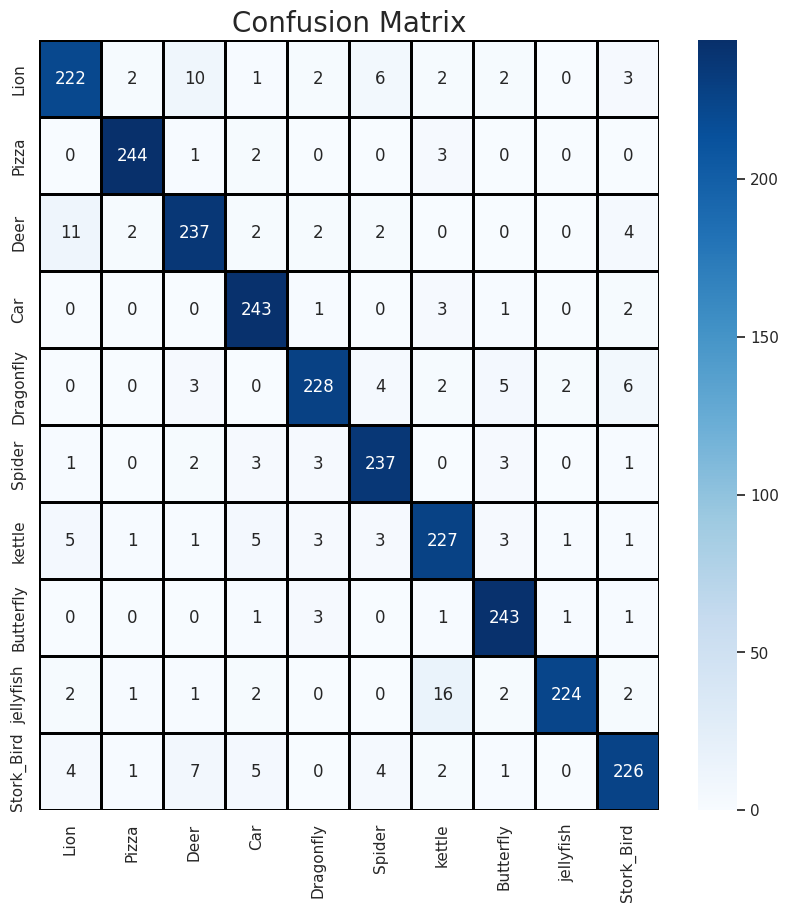

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 1s 14ms/step


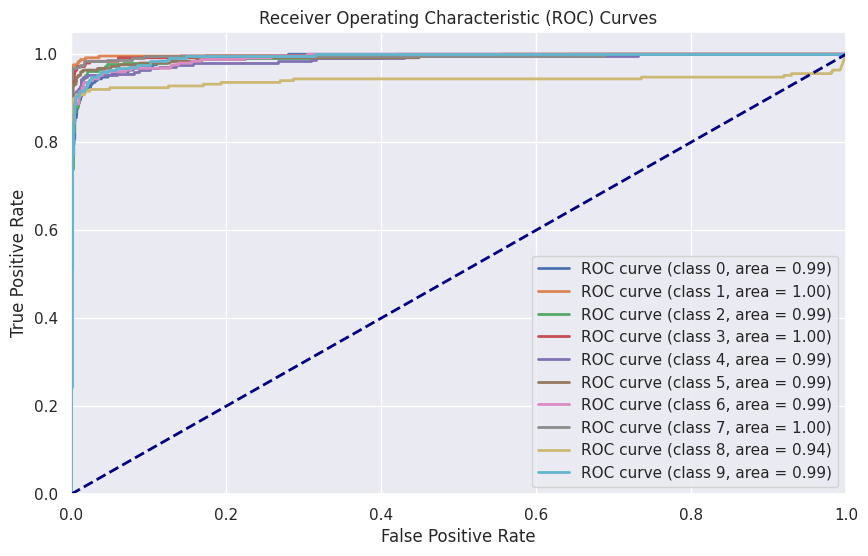

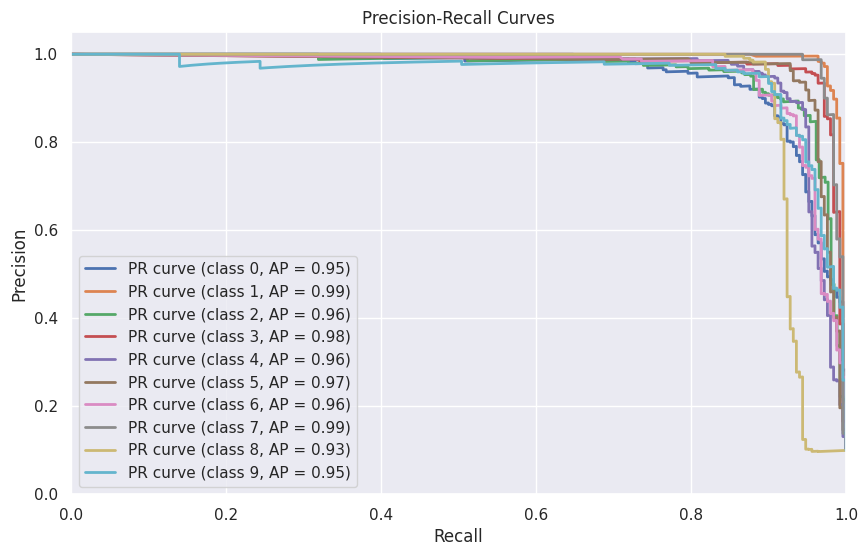

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = resnet_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

VGG19

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam

VGG19_basic_model = VGG19(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# Freeze all layers of the pre-trained model
for layer in VGG19_basic_model.layers:
    layer.trainable = False
VGG19_model = Sequential()
VGG19_model.add(VGG19_basic_model)
VGG19_model.add(Flatten())
VGG19_model.add(Dense(128, activation='relu'))
VGG19_model.add(Dense(10, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
VGG19_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
VGG19_pretrained = VGG19_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/200
157/157 [==============================] - 19s 54ms/step - loss: 1.1763 - accuracy: 0.6023 - val_loss: 0.7568 - val_accuracy: 0.7432
Epoch 2/200
157/157 [==============================] - 6s 37ms/step - loss: 0.8667 - accuracy: 0.7042 - val_loss: 0.6427 - val_accuracy: 0.7824
Epoch 3/200
157/157 [==============================] - 6s 37ms/step - loss: 0.7648 - accuracy: 0.7393 - val_loss: 0.5541 - val_accuracy: 0.8192
Epoch 4/200
157/157 [==============================] - 6s 38ms/step - loss: 0.6769 - accuracy: 0.7689 - val_loss: 0.5347 - val_accuracy: 0.8224
Epoch 5/200
157/157 [==============================] - 6s 36ms/step - loss: 0.6154 - accuracy: 0.7942 - val_loss: 0.4636 - val_accuracy: 0.8528
Epoch 6/200
157/157 [==============================] - 6s 37ms/step - loss: 0.5629 - accuracy: 0.8099 - val_loss: 0.4568 - val_accuracy: 0.8532
Epoch 7/200
157/157 [==============================] - 6s 36ms/step - loss: 0.5235 - accuracy: 0.8228 - val_loss: 0.3983 - val_accuracy

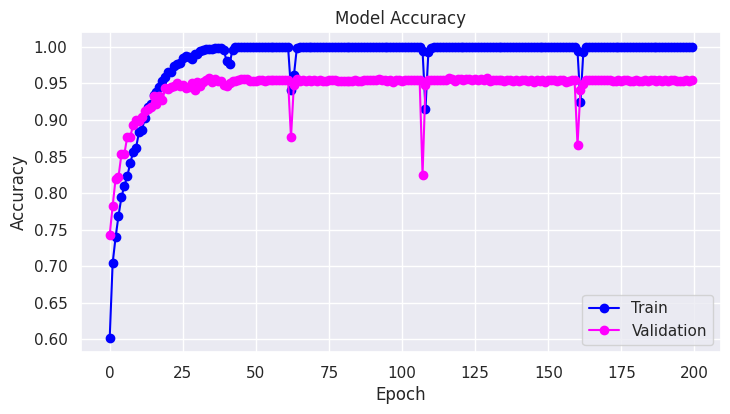

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG19_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(VGG19_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

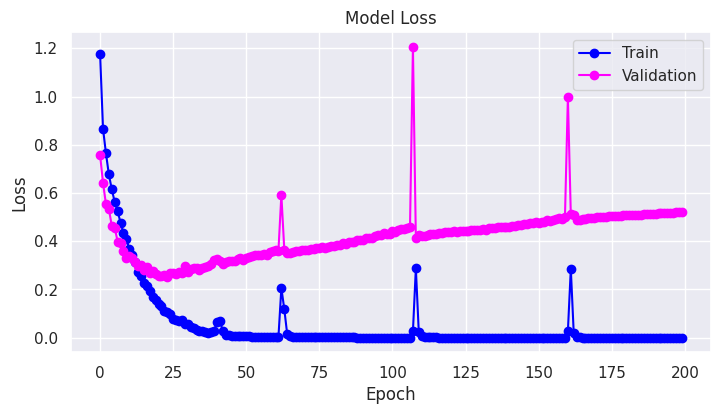

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG19_pretrained.history['loss'],'o-', color="blue")
plt.plot(VGG19_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = VGG19_model.evaluate(X_test, Y_test)
train_loss, train_acc=VGG19_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

314/314 [==============================] - 6s 19ms/step - loss: 9.4663e-05 - accuracy: 1.0000

Test Accuracy: 0.9539999961853027

Test Loss: 0.5216645002365112

Train Accuracy: 1.0

Train Loss: 9.466268966207281e-05


In [ ]:
score = VGG19_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  95.4 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(VGG19_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

79/79 [==============================] - 2s 17ms/step
[0 0 0 ... 9 9 9]
(2500,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[237,   2,   0,   0,   2,   3,   0,   2,   1,   3],
       [  4, 235,   1,   0,   7,   0,   0,   0,   3,   0],
       [  0,   0, 246,   0,   1,   0,   1,   1,   1,   0],
       [  0,   2,   0, 241,   1,   1,   2,   0,   1,   2],
       [  5,   4,   0,   0, 230,   1,   0,   2,   7,   1],
       [  6,   0,   0,   1,   2, 233,   3,   1,   1,   3],
       [  1,   0,   1,   0,   1,   3, 243,   0,   1,   0],
       [  0,   1,   0,   0,   1,   0,   0, 248,   0,   0],
       [  0,   2,   0,   0,  11,   1,   0,   0, 235,   1],
       [  1,   4,   1,   2,   1,   2,   1,   0,   1, 237]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

      Spider      0.933     0.948     0.940       250
        Lion      0.940     0.940     0.940       250
       Pizza      0.988     0.984     0.986       250
   jellyfish      0.988     0.964     0.976       250
        Deer      0.895     0.920     0.907       250
   Dragonfly      0.955     0.932     0.943       250
   Butterfly      0.972     0.972     0.972       250
         Car      0.976     0.992     0.984       250
  Stork_Bird      0.936     0.940     0.938       250
      kettle      0.960     0.948     0.954       250

    accuracy                          0.954      2500
   macro avg      0.954     0.954     0.954      2500
weighted avg      0.954     0.954     0.954      2500



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'] , columns = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'])

<Axes: title={'center': 'Confusion Matrix'}>

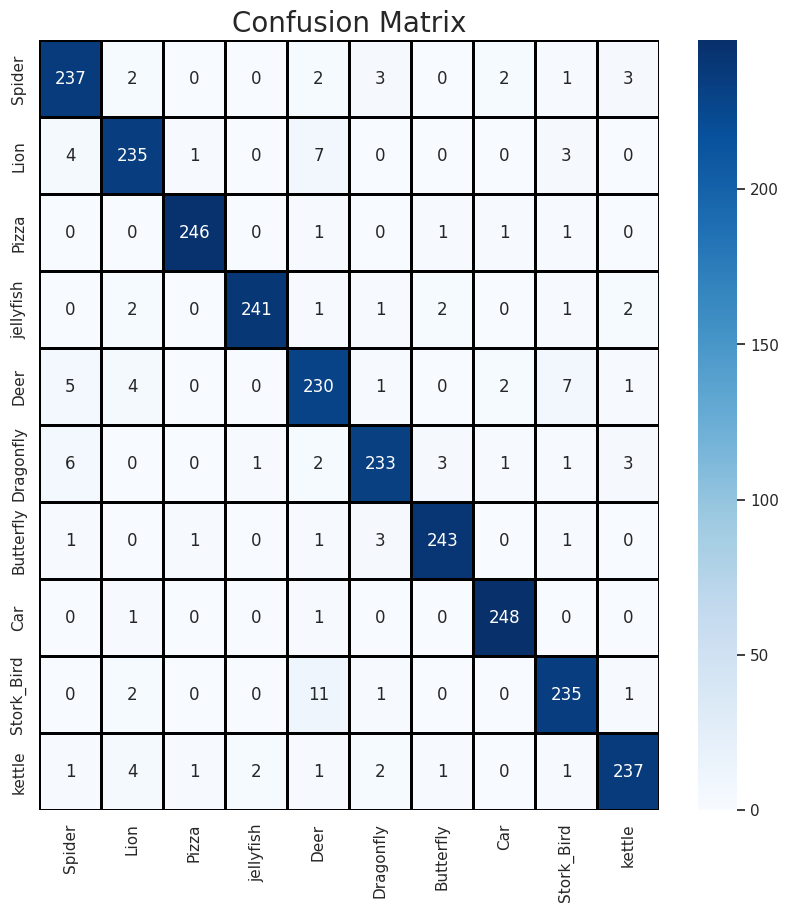

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 1s 18ms/step


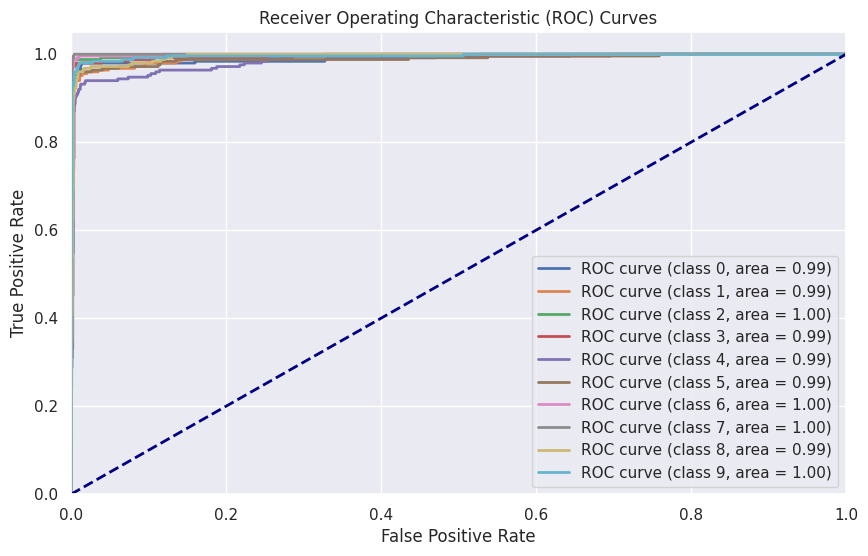

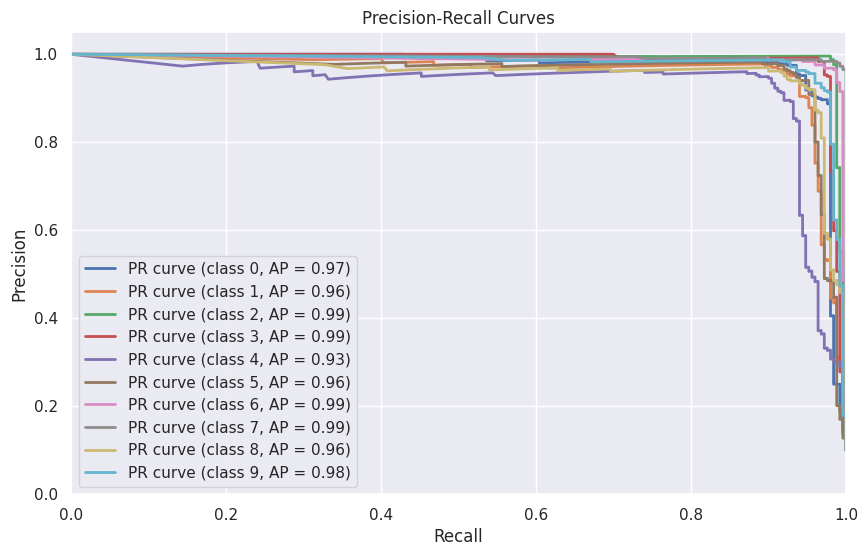

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = VGG19_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

Densenet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model with pre-trained weights (include_top=False for feature extraction)
DenseNet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all layers of the pre-trained model
for layer in DenseNet121_model.layers:
    layer.trainable = False

# Create a new Sequential model
DenseNet121_custom_model = Sequential()
DenseNet121_custom_model.add(DenseNet121_model)
DenseNet121_custom_model.add(Flatten())
DenseNet121_custom_model.add(Dense(128, activation='relu'))
DenseNet121_custom_model.add(Dense(10, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
DenseNet121_custom_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
DenseNet121_pretrained = DenseNet121_custom_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/200
157/157 [==============================] - 18s 58ms/step - loss: 1.0464 - accuracy: 0.6781 - val_loss: 0.4151 - val_accuracy: 0.8648
Epoch 2/200
157/157 [==============================] - 6s 35ms/step - loss: 0.6109 - accuracy: 0.7947 - val_loss: 0.3473 - val_accuracy: 0.8864
Epoch 3/200
157/157 [==============================] - 5s 30ms/step - loss: 0.4946 - accuracy: 0.8304 - val_loss: 0.2698 - val_accuracy: 0.9120
Epoch 4/200
157/157 [==============================] - 5s 33ms/step - loss: 0.4002 - accuracy: 0.8628 - val_loss: 0.2589 - val_accuracy: 0.9156
Epoch 5/200
157/157 [==============================] - 5s 31ms/step - loss: 0.3379 - accuracy: 0.8809 - val_loss: 0.2439 - val_accuracy: 0.9232
Epoch 6/200
157/157 [==============================] - 5s 30ms/step - loss: 0.2887 - accuracy: 0.8976 - val_loss: 0.1943 - val_accuracy: 0.9452
Epoch 7/200
157/157 [==============================] - 5s 33ms/step - loss: 0.2215 - accuracy: 0.9248 - val_loss: 0.1790 - val_accuracy

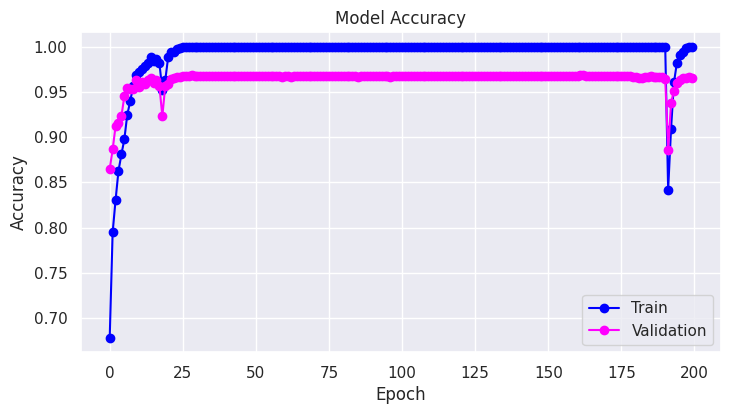

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(DenseNet121_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

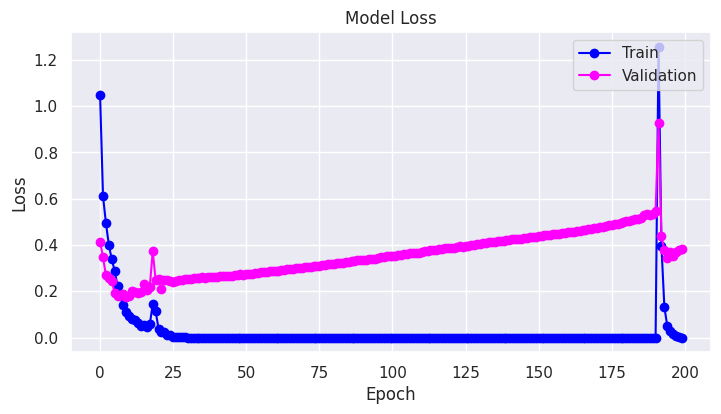

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['loss'],'o-', color="blue")
plt.plot(DenseNet121_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = DenseNet121_custom_model.evaluate(X_test, Y_test)
train_loss, train_acc = DenseNet121_custom_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

314/314 [==============================] - 5s 16ms/step - loss: 6.0694e-04 - accuracy: 1.0000

Test Accuracy: 0.9660000205039978

Test Loss: 0.3808545172214508

Train Accuracy: 1.0

Train Loss: 0.0006069405353628099


In [ ]:
score = DenseNet121_custom_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  96.6 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(DenseNet121_custom_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

79/79 [==============================] - 4s 15ms/step
[4 0 0 ... 9 9 9]
(2500,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[242,   0,   0,   0,   1,   3,   0,   2,   0,   2],
       [  2, 241,   0,   0,   1,   0,   0,   2,   4,   0],
       [  1,   1, 244,   0,   0,   1,   2,   0,   0,   1],
       [  3,   2,   2, 238,   0,   1,   0,   0,   0,   4],
       [  1,   2,   0,   0, 236,   1,   0,   0,  10,   0],
       [  5,   0,   0,   1,   0, 242,   2,   0,   0,   0],
       [  2,   0,   0,   0,   1,   2, 245,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0,   0, 248,   0,   0],
       [  0,   3,   0,   0,   8,   0,   0,   0, 239,   0],
       [  2,   2,   1,   0,   2,   0,   1,   2,   0, 240]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

      Spider      0.938     0.968     0.953       250
        Lion      0.960     0.964     0.962       250
       Pizza      0.988     0.976     0.982       250
   jellyfish      0.996     0.952     0.973       250
        Deer      0.940     0.944     0.942       250
   Dragonfly      0.968     0.968     0.968       250
   Butterfly      0.980     0.980     0.980       250
         Car      0.976     0.992     0.984       250
  Stork_Bird      0.945     0.956     0.950       250
      kettle      0.972     0.960     0.966       250

    accuracy                          0.966      2500
   macro avg      0.966     0.966     0.966      2500
weighted avg      0.966     0.966     0.966      2500



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'] , columns = ['Lion', 'Pizza', 'Deer', 'Car', 'Dragonfly', 'Spider', 'kettle', 'Butterfly', 'jellyfish', 'Stork_Bird'])

<Axes: title={'center': 'Confusion Matrix'}>

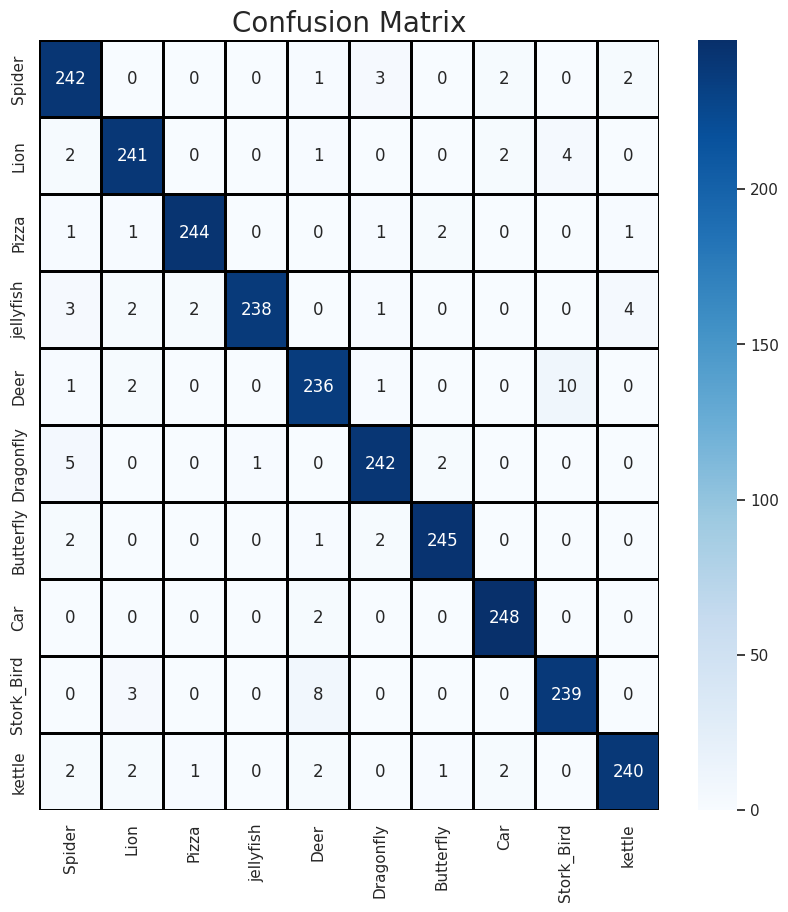

In [ ]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 1s 13ms/step


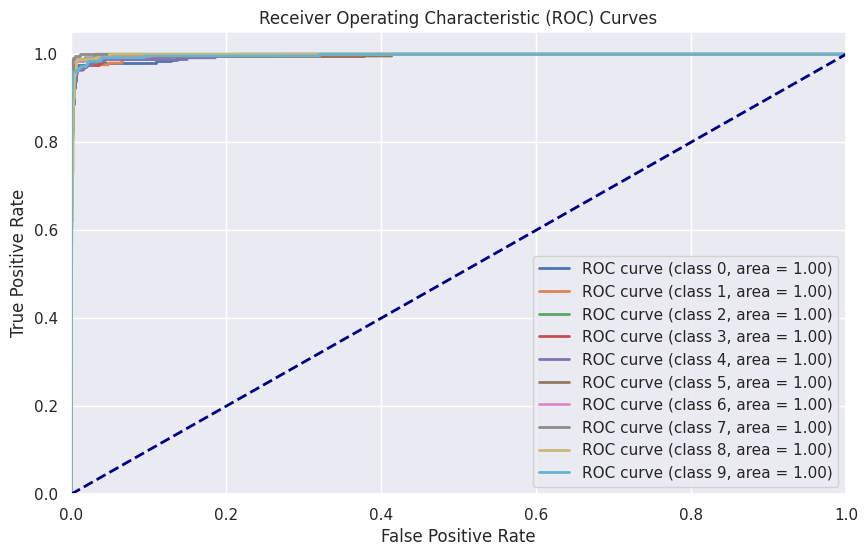

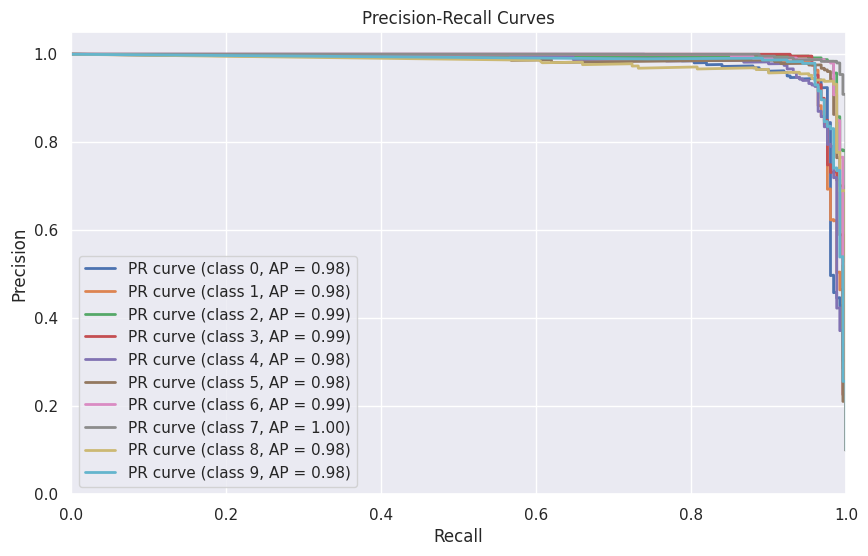

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = DenseNet121_custom_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()